This notebook contains the code to reproduce some of the figures in the report. Estimating alpha, the proportion of sentences modified by GPT takes a while. We recommend storing the results to avoid time-consuming runs. The code has a provision to store the results. 

In [7]:
from base import * 
import pandas as pd 
import os 
import pickle 
from pathlib import Path 
from src.estimation import estimate_text_distribution
from src.MLE import MLE
import warnings
import numpy as np 
import matplotlib.pyplot as plt 
from copy import deepcopy 
warnings.filterwarnings("ignore")
import seaborn as sns 
from datetime import datetime

In [8]:
def load_pkl_files(folder_path, filename):
    """
    load the pkl files
    
    Args:
        folder_path: (str) path to the folder
        filename: (str) name of the file

    Return:
        (object)
    """
    folder_path = Path(folder_path)
    try:
        with open(folder_path / filename, "rb") as f:
            data = pickle.load(f)
            f.close()
            return data
    except FileNotFoundError:
        print("Specified path is not correct. Enter the correct path / filename")


In [9]:
def plot_line_graph(x_dict, y_dict, x_lab, y_lab, title, CI=None, ax=None,legend_key=None, 
                    save=False, save_name="figure", save_folder="figure_folder", 
                    fig_format=".pdf", show_legend=True, legend_title="legend",
                    palette = ["#FF9999", "#D3D3D3", "#8B0000", "#00008B"], 
                    grid=True, font_size=13, **kwargs):
    
    """
    plots a line graph
    
    Args:
        x_dict: (dict) (object) -> (np.ndarray) the x-axis values
        y_dict: (dict) (object) -> (np.ndarray) the y-axis values; the key must be
                        the same as in y-axis
        x_lab: (str) the x-axis label
        y_lab: (str) the y-axis label
        title: (str) title
        CI: (dict) the confidence interval
        ax: (axes) the axis on which the figure is to be made
        legend_key: (dict) (object) -> (object) the legend for the plot.
                            the key needs to be same as in x_dict
        save: (bool) whether to save the figure or not 
        save_name: (str) name of the figure 
        save_folder: (str) path to the folder where figure is saved 
        fig_format: (str) format in which the figure is saved
        show_legend: (bool) whether to show legend or not 
        palette: (List[str]) the colors to use 
        grid: (bool) whether to add gridlines or not
    """
    
    data = []
    for key in x_dict:
        for x, y, ci in zip(x_dict[key], y_dict[key], CI[key]):
            data.append({'Time': x, 'Alpha': y, 'CI': ci, legend_title: key})
    df = pd.DataFrame(data)

    sns.set_palette(palette)
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.add_subplot(1, 1, 1)
    ax = sns.lineplot(data=df, x='Time', y='Alpha', hue=legend_title, ax=ax, marker="o",
                     markersize=5, linewidth=0.1, style=legend_title, dashes=False, markers=["o", "o"])
    
    for c, key in enumerate(x_dict):
        ax.errorbar(x_dict[key], y_dict[key], yerr=CI[key], color=palette[c], capsize=3)
    
    ax.set_xlabel(x_lab, fontsize=font_size+1, fontweight="bold")
    ax.set_ylabel(y_lab, fontsize=font_size+1, fontweight="bold")
    ax.set_title(title, fontsize=font_size+2, fontweight="bold")
    if "x_ticks" in kwargs:
        ax.set_xticks(kwargs["x_ticks"])
        if "x_ticklabels" in kwargs:
            ax.set_xticklabels(kwargs["x_ticklabels"], rotation=45, fontsize=font_size)
    
    if show_legend:
        ax.legend(title=legend_title, fontsize=font_size-1, title_fontsize=font_size)
    else:
        ax.get_legend().set_visible(False)

    if "vline" in kwargs:
        ax.axvline(kwargs["vline"], color="black", ls="--")
        y_max = df['Alpha'].max()
        if "annotation" in kwargs:
            ax.annotate(kwargs["annotation"], (kwargs["vline"], y_max/2), xytext=(kwargs["vline"] + 0.25, y_max/2+0.02))
    ax.tick_params(axis='both', labelsize=font_size)
    if save:
        path = Path(save_folder)
        path.mkdir(parents=True, exist_ok=True)
        full_path = path / f"{save_name}{fig_format}"
        plt.savefig(full_path, bbox_inches="tight", dpi=300)
    if grid:
        ax.grid()
        
        
    plt.show()
    plt.close()

In [10]:
def convert_to_array(all_results, key2_lim=np.infty):
    """
    extracts the alpha and confidence interval values from a dictionary
    and converts them into array
    Args:
        all_results: (dict) -> (int) year -> (dict)  (int) month ->(int, int) alpha , CI
        key2_lim: (int) the restriction on month / quarter; to handle data for 2024
    Returns:
        (np.ndarray, np.ndarray, List[str])
    """

    alpha_li = []
    ci_li = []
    year_month = []
    for key1 in sorted(all_results.keys()):
        for key2 in sorted(all_results[key1]):
            if key1 != 2024:
                alpha_li.append(all_results[key1][key2][0])
                ci_li.append(all_results[key1][key2][1])
                year_month.append("{}-{}".format(key1, key2))
            else:
                if key2 < key2_lim:
                    alpha_li.append(all_results[key1][key2][0])
                    ci_li.append(all_results[key1][key2][1])
                    year_month.append("{}-{}".format(key1, key2))
    return np.asarray(alpha_li), np.asarray(ci_li), year_month


def get_date(start_year, end_year, start_month, end_month, interval=1):
    """
    gets the dates for the relevant period

    Args:
        start_year: (int)
        end_year: (int)
        start_month: (int)
        end_month: (int)
        interval: (int)

    Returns:
        List([str])
    """
    
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)

    all_dates = []
    curr_date = start_date
    while curr_date <= end_date:
        all_dates.append(curr_date.strftime("%Y-%m"))
        # Move to the next month
        if curr_date.month == 12:
            curr_date = curr_date.replace(year=curr_date.year + 1, month=1)
        else:
            if curr_date.month + interval > 12:
                curr_date = curr_date.replace(year=curr_date.year + 1, month=interval - 12 + curr_date.month)
            else:
                curr_date = curr_date.replace(month=curr_date.month + interval)
    return all_dates

In [12]:
## the key variables 

subject = "education"
base_loc = f"inference_data/{subject}"
years = [2024, 2023, 2022, 2021]

## Overall Trend

### Estimate $\alpha$

This takes a while. Run it once and save the results. If the results are available, jump to the cell that makes the figure i.e. cell titled "Make Plot"

In [17]:
parquet_base_loc = "inference_data/parquet_files/time_trend/{}".format(subject)
# we will save all results into a dictionary
name = "ojs_ed_21"
all_results = {}

## change the location if need be. 
model= MLE(f"distribution/{name}.parquet")

for year in [2024, 2023, 2022, 2021]:
    if year not in all_results:
        all_results[year] = {}
    parquet_year_path = "{}/{}".format(parquet_base_loc, year) 
    for f in sorted(os.listdir(parquet_year_path)):
        if ".parquet" in f and "whole" not in f:
            month = int(f.strip(".parquet").split("_")[-1])
            full_path = "{}/{}".format(parquet_year_path, f)
            estimated,ci = model.inference(full_path,
                                     ground_truth=None, save=False)
            if estimated is not None and ci is not None :
                print(f"filename: {f}, alpha: {estimated:.3f}, std: {ci:.3f}")
                all_results[year][month] = (estimated, ci)

filename: education_2024_1.parquet, alpha: 0.256, std: 0.007
ERROR
ERROR
filename: education_2024_12.parquet, alpha: 0.427, std: 0.309
filename: education_2024_2.parquet, alpha: 0.291, std: 0.009
filename: education_2024_3.parquet, alpha: 0.289, std: 0.008
filename: education_2024_4.parquet, alpha: 0.295, std: 0.012
filename: education_2024_5.parquet, alpha: 0.350, std: 0.151
filename: education_2024_6.parquet, alpha: 0.218, std: 0.066
ERROR
filename: education_2024_8.parquet, alpha: 0.502, std: 0.182
ERROR
filename: education_2023_1.parquet, alpha: 0.053, std: 0.004
filename: education_2023_10.parquet, alpha: 0.183, std: 0.006
filename: education_2023_11.parquet, alpha: 0.206, std: 0.006
filename: education_2023_12.parquet, alpha: 0.223, std: 0.005
filename: education_2023_2.parquet, alpha: 0.071, std: 0.005
filename: education_2023_3.parquet, alpha: 0.101, std: 0.005
filename: education_2023_4.parquet, alpha: 0.106, std: 0.005
filename: education_2023_5.parquet, alpha: 0.127, std: 0.

### Save the results. 

Skip to the next cell, if this is already done 

In [20]:
output_folder = Path("output")
output_folder.mkdir(parents=True, exist_ok=True) 
with open(output_folder / "time_trend_results.pkl", "wb") as f:
    pickle.dump(all_results, f) 

### Make Plot

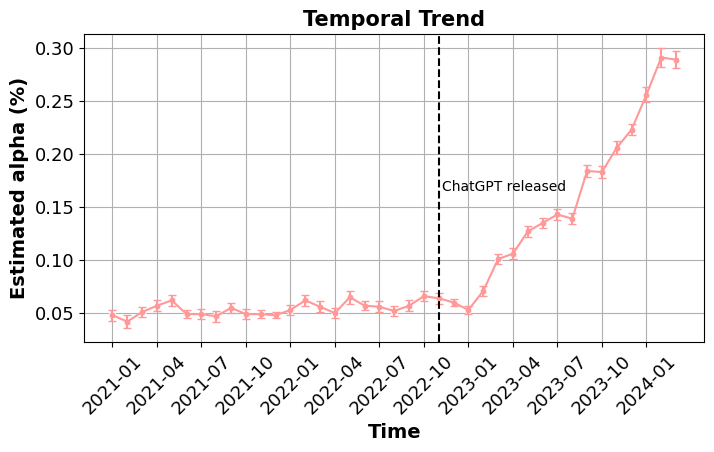

In [21]:
output_dir = Path("output") # path to the folder where the relevant outputs are saved 
results_time_trend = load_pkl_files(output_dir, "time_trend_results.pkl")
time_trend_alpha, time_trend_ci, time_trend_ym = convert_to_array(results_time_trend, 
                                                                  key2_lim=4)

x_dict_time = {"all":np.arange(1, len(time_trend_ym)+1)}
y_dict_time = {"all": time_trend_alpha }
ci_dict_time = {"all": time_trend_ci}
all_dates = get_date(2021, 2024, 1, 4, interval=1)
x_dates = [all_dates[i-1] for i in range(1, 40, 3)]
plot_line_graph(x_dict_time, y_dict_time, "Time", "Estimated alpha (%)", "Temporal Trend", CI=ci_dict_time, ax=None,
                    legend_key=None, show_legend=False, save=True, save_name="alpha_time", 
                    x_ticks=np.arange(1, 40, 3), x_ticklabels=x_dates,vline=23, annotation="ChatGPT released")


## Author Frequency

### Estimate $\alpha$

This takes a while. Run it once and save the results. If the results are available, jump to the cell that makes the figure i.e. cell titled "Make Plot"

In [35]:
parquet_base_loc = "inference_data/parquet_files/first_author_quarterly/{}".format(subject)
name = "ojs_ed_21"
all_results_less_freq = {}
all_results_more_freq = {}
model= MLE(f"distribution/{name}.parquet")
for year in [2024, 2023, 2022, 2021]:
    if year not in all_results_less_freq:
        all_results_less_freq[year] = {}
    if year not in all_results_more_freq:
        all_results_more_freq[year] = {}
    parquet_year_path = "{}/{}".format(parquet_base_loc, year) 
    for f in sorted(os.listdir(parquet_year_path)):
        if ".parquet" in f and "whole" not in f:
            quarter = int(f.strip(".parquet").split("_")[-2])
            full_path = "{}/{}".format(parquet_year_path, f)
            estimated,ci = model.inference(full_path,
                                     ground_truth=None, save=False)
            if estimated is not None and ci is not None :
                print(f"filename: {f}, alpha: {estimated:.3f}, std: {ci:.3f}")

                if "less" in f:
                    all_results_less_freq[year][quarter] = (estimated, ci)
                elif "more" in f:
                    all_results_more_freq[year][quarter] = (estimated, ci)

filename: education_2024_1_less.parquet, alpha: 0.276, std: 0.004
filename: education_2024_1_more.parquet, alpha: 0.535, std: 0.033
filename: education_2024_2_less.parquet, alpha: 0.298, std: 0.012
filename: education_2024_2_more.parquet, alpha: 0.234, std: 0.132
filename: education_2024_3_less.parquet, alpha: 0.501, std: 0.178
ERROR
filename: education_2024_4_less.parquet, alpha: 0.443, std: 0.317
ERROR
filename: education_2023_1_less.parquet, alpha: 0.079, std: 0.003
filename: education_2023_1_more.parquet, alpha: 0.090, std: 0.013
filename: education_2023_2_less.parquet, alpha: 0.122, std: 0.003
filename: education_2023_2_more.parquet, alpha: 0.224, std: 0.014
filename: education_2023_3_less.parquet, alpha: 0.154, std: 0.003
filename: education_2023_3_more.parquet, alpha: 0.213, std: 0.017
filename: education_2023_4_less.parquet, alpha: 0.212, std: 0.004
filename: education_2023_4_more.parquet, alpha: 0.249, std: 0.022
filename: education_2022_1_less.parquet, alpha: 0.058, std: 0.00

### Save the results. 

Skip to the next cell, if this is already done 

In [36]:
with open(output_folder / "first_author_trend_results_less_quarter.pkl", "wb") as f:
    pickle.dump(all_results_less_freq, f) 
with open(output_folder / "first_author_trend_results_more_quarter.pkl", "wb") as f:
    pickle.dump(all_results_more_freq, f)
print(all_results_less)

{2024: {12: (0.419, 0.325), 1: (0.3, 0.011), 2: (0.377, 0.012), 3: (0.341, 0.012), 4: (0.344, 0.016), 5: (0.327, 0.159), 6: (0.187, 0.128), 8: (0.745, 0.195)}, 2023: {10: (0.238, 0.01), 11: (0.266, 0.01), 12: (0.282, 0.008), 1: (0.073, 0.007), 2: (0.095, 0.007), 3: (0.124, 0.007), 4: (0.142, 0.008), 5: (0.157, 0.008), 6: (0.18, 0.007), 7: (0.173, 0.008), 8: (0.18, 0.009), 9: (0.244, 0.01)}, 2022: {10: (0.082, 0.007), 11: (0.087, 0.007), 12: (0.084, 0.005), 1: (0.071, 0.007), 2: (0.065, 0.007), 3: (0.08, 0.007), 4: (0.071, 0.007), 5: (0.073, 0.007), 6: (0.065, 0.005), 7: (0.071, 0.007), 8: (0.075, 0.007), 9: (0.066, 0.007)}, 2021: {10: (0.049, 0.007), 11: (0.065, 0.007), 12: (0.06, 0.005), 1: (0.055, 0.007), 2: (0.051, 0.007), 3: (0.053, 0.006), 4: (0.075, 0.007), 5: (0.07, 0.007), 6: (0.057, 0.006), 7: (0.061, 0.006), 8: (0.062, 0.007), 9: (0.062, 0.007)}}


### Make plot

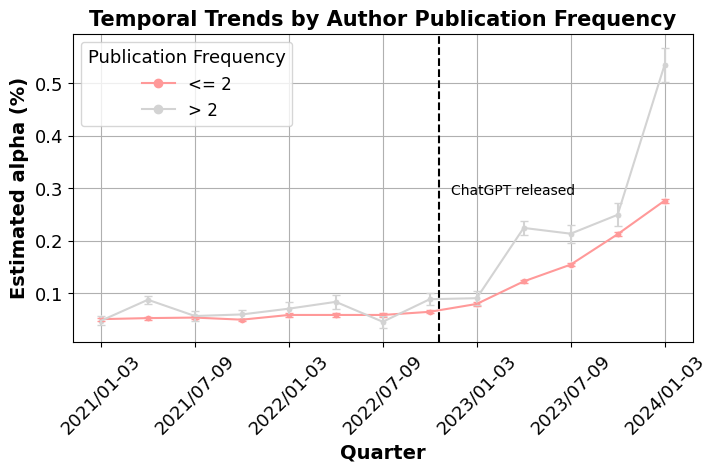

In [37]:
# variation in alpha according to the publication frequency of first authors 
results_first_authors_less = load_pkl_files(output_dir, "first_author_trend_results_less_quarter.pkl")
alpha_author_trend_less, author_trend_less_ci, author_trend_less_ym = convert_to_array(results_first_authors_less, key2_lim=2)

results_first_authors_more = load_pkl_files(output_dir, "first_author_trend_results_more_quarter.pkl")
alpha_author_trend_more, author_trend_more_ci, author_trend_more_ym = convert_to_array(results_first_authors_more, key2_lim=2)

x_dict_first_authors = {"<= 2":np.arange(1, len(author_trend_less_ym)+1), 
                        "> 2":np.arange(1, len(author_trend_more_ym)+1)}
y_dict_first_authors = {"<= 2":alpha_author_trend_less , "> 2" : alpha_author_trend_more}

ci_dict_first_authors = {"<= 2": author_trend_less_ci , "> 2" : author_trend_more_ci}

x_ticks = np.arange(1, 14, 2)
x_dates = get_date(2021, 2024, 1, 4, 3)
new_dates = []
for d in x_dates:
    m_start_int = int(d.split("-")[-1])
    y = int(d.split("-")[0])
    m_start = datetime(y, m_start_int, 1).strftime("%m")
    try:
        m_end = datetime(y, m_start_int+2, 1).strftime("%m")
    except ValueError:
        m_end = datetime(y+1, 12 - m_start_int +2, 1).strftime("%m")
    new_dates.append(f"{y}/{m_start}-{m_end}")
x_dates = [new_dates[i-1] for i in range(1, 14, 2)]

plot_line_graph(x_dict_first_authors, y_dict_first_authors, "Quarter", "Estimated alpha (%)", "Temporal Trends by Author Publication Frequency", CI=ci_dict_first_authors, 
               legend_title="Publication Frequency", x_ticks=x_ticks, x_ticklabels=x_dates, save=True, 
               save_name="pub_freq", show_legend=True, vline=8.2, annotation="ChatGPT released")

## Number of Authors

### Estimate $\alpha$

This takes a while. Run it once and save the results. If the results are available, jump to the cell that makes the figure i.e. cell titled "Make Plot"

In [23]:
parquet_base_loc = "inference_data/parquet_files/num_authors/{}".format(subject)
name = "ojs_ed_21"
all_results_less = {}
all_results_more = {}
model= MLE(f"distribution/{name}.parquet")
for year in [2024, 2023, 2022, 2021]:
    if year not in all_results_less:
        all_results_less[year] = {}
    if year not in all_results_more:
        all_results_more[year] = {}
    parquet_year_path = "{}/{}".format(parquet_base_loc, year) 
    for f in sorted(os.listdir(parquet_year_path)):
        if ".parquet" in f and "whole" not in f:
            quarter = int(f.strip(".parquet").split("_")[-2])
            full_path = "{}/{}".format(parquet_year_path, f)
            estimated,ci = model.inference(full_path,
                                     ground_truth=None, save=False)
            if estimated is not None and ci is not None :
                print(f"filename: {f}, alpha: {estimated:.3f}, std: {ci:.3f}")

                if "less" in f:
                    all_results_less[year][quarter] = (estimated, ci)
                elif "more" in f:
                    all_results_more[year][quarter] = (estimated, ci)

filename: education_2024_1.parquet, alpha: 0.263, std: 0.007
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
filename: education_2024_12.parquet, alpha: 0.463, std: 0.323
filename: education_2024_12_less.parquet, alpha: 0.419, std: 0.325
ERROR
filename: education_2024_1_less.parquet, alpha: 0.300, std: 0.011
filename: education_2024_1_more.parquet, alpha: 0.221, std: 0.010
filename: education_2024_2.parquet, alpha: 0.298, std: 0.009
filename: education_2024_2_less.parquet, alpha: 0.377, std: 0.012
filename: education_2024_2_more.parquet, alpha: 0.195, std: 0.012
filename: education_2024_3.parquet, alpha: 0.294, std: 0.008
filename: education_2024_3_less.parquet, alpha: 0.341, std: 0.012
filename: education_2024_3_more.parquet, alpha: 0.236, std: 0.011
filename: education_2024_4.parquet, alpha: 0.300, std: 0.012
filename: education_2024_4_less.parquet, alpha: 0.344, std: 0.016
filename: education_2024_4_more.parquet, alpha: 0.232, std: 0.019
filename: education_2024_5.parquet, alpha: 0.349, std: 0.

filename: education_2021_8_less.parquet, alpha: 0.062, std: 0.007
filename: education_2021_8_more.parquet, alpha: 0.033, std: 0.006
filename: education_2021_9.parquet, alpha: 0.059, std: 0.005
filename: education_2021_9_less.parquet, alpha: 0.062, std: 0.007
filename: education_2021_9_more.parquet, alpha: 0.053, std: 0.007


### Save the results. 

Skip to the next cell, if this is already done 

In [29]:
with open(output_folder / "num_author_trend_results_less_quarter.pkl", "wb") as f:
    pickle.dump(all_results_less, f) 
with open(output_folder / "num_author_trend_results_more_quarter.pkl", "wb") as f:
    pickle.dump(all_results_more, f)

## Make Plot

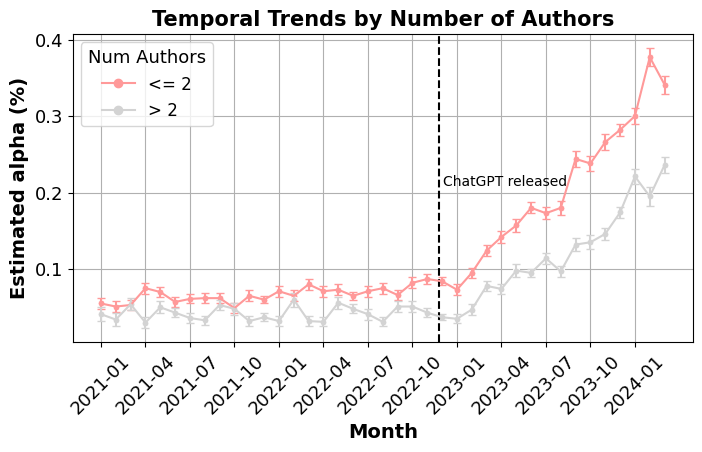

In [30]:
# variation in alpha according to number of authors in an article 
results_num_authors_less = load_pkl_files(output_dir, "num_author_trend_results_less_quarter.pkl")
results_num_authors_more = load_pkl_files(output_dir, "num_author_trend_results_more_quarter.pkl")

# variation in alpha according to the publication frequency of first authors 
results_first_authors_less = load_pkl_files(output_dir, "first_author_trend_results_less_quarter.pkl")
alpha_less, ci_less, time_less = convert_to_array(results_num_authors_less, key2_lim=4)

results_first_authors_more = load_pkl_files(output_dir, "first_author_trend_results_more_quarter.pkl")
alpha_more, ci_more, time_more = convert_to_array(results_num_authors_more, key2_lim=4)

dict_x = {"<= 2":np.arange(1, len(alpha_less)+1), 
                        "> 2":np.arange(1, len(alpha_more)+1)}
dict_y = {"<= 2":alpha_less , "> 2" : alpha_more}
dict_ci = {"<= 2": ci_less , "> 2" : ci_more}
x_dates = [all_dates[i-1] for i in range(1, 40, 3)]

plot_line_graph(dict_x, dict_y, "Month", "Estimated alpha (%)", "Temporal Trends by Number of Authors", CI=dict_ci, 
               legend_title="Num Authors", x_ticks=np.arange(1, 40, 3), x_ticklabels=x_dates, save=True, 
               save_name="num_authors", show_legend=True, vline=23.8, annotation="ChatGPT released")